In [1]:
import os
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab - Setting up environment...")
    from google.colab import drive
    drive.mount('/content/drive')
    
    repo_url = "https://github.com/pooyaht/dl_hw2"
    clone_path = "/content/drive/MyDrive/dl_hw2"
    
    if not os.path.exists(clone_path):
        print(f"Cloning repository to {clone_path}...")
        !git clone {repo_url} {clone_path}
    else:
        print(f"Repository already exists at {clone_path}")
    
    os.chdir(clone_path)
    print(f"Changed working directory to: {os.getcwd()}")
    
    if clone_path not in sys.path:
        sys.path.append(clone_path)
else:
    print("Running locally")
    

Running locally


In [2]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

import json
from pathlib import Path
from datetime import datetime

from resnet_YOLO_model import SimpleResNetYOLO 
from coco_downloader import COCOCatDogDownloader
from dataloader import create_split_datasets, create_dataloaders
from yolo_helpers import create_yolo_targets, decode_yolo_predictions, yolo_loss

In [3]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda'
        print(f"CUDA available: Using GPU - {torch.cuda.get_device_name()}")
    elif torch.backends.mps.is_available():
        device = 'mps'
        print("MPS available: Using Apple Silicon GPU")
    else:
        device = 'cpu'
        print("Using CPU")
    return device

experiment_config = {
    'model': 'resnet50',
    'num_anchors': 3,
    "grid_size": 14,
    'batch_size': 8,
    'num_epochs': 50,
    'val_ratio': 0.2,
    'unfreeze_partial_epoch': 12,  
    'unfreeze_all_epoch': 38,     
    'device': get_device(),
    'target_size': (448, 448),
    'lr_frozen': 1e-3,      
    'lr_partial': 1e-5,     
    'lr_all': 1e-6,         
    'weight_decay': 1e-3,  
    'dropout_rate': 0.4,
    'use_augmentation': True,
    'use_bg_removal': True,
    'bg_removal_p': 0.5,
    'coord_weight': 1,
    'augmentation_strength': 0.5
}

MPS available: Using Apple Silicon GPU


In [4]:
downloader = COCOCatDogDownloader()
downloader.download_and_prepare_dataset()

Annotations already exist, skipping download
loading annotations into memory...
Done (t=9.94s)
creating index...
index created!
Cat category ID: [17]
Dog category ID: [18]
Found 4078 pure cat images
Found 4342 pure dog images
Found 220 mixed images
Selected 220 mixed images (all)
Selected 2500 pure cat images
Selected 2500 pure dog images


100%|██████████| 5220/5220 [00:00<00:00, 123608.43it/s]


In [5]:
annotations_file = "cat_dog_images/cat_dog_annotations.json"

train_file, val_file = create_split_datasets(
    annotations_file, val_ratio=experiment_config['val_ratio'])

train_loader, val_loader = create_dataloaders(
    train_file, val_file, 
    batch_size=experiment_config['batch_size'],
    target_size=experiment_config['target_size'],
    use_albumentations=experiment_config['use_augmentation'],
    use_bg_removal=experiment_config['use_bg_removal'],
    augmentation_strength=experiment_config['augmentation_strength'],
    bg_removal_p=experiment_config['bg_removal_p']
)


Split Results:
Training set: 4176 images
- Mixed: 176
- Pure cat: 2000
- Pure dog: 2000
Validation set: 1044 images
- Mixed: 44
- Pure cat: 500
- Pure dog: 500

Saved:
- Training annotations: cat_dog_images/train_annotations.json
- Validation annotations: cat_dog_images/val_annotations.json


/Users/tobysmith/Desktop/Desktop/dev/python/ML/DL/HW2/.venv/lib/python3.13/site-packages/albumentations/core/composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


In [6]:
def calculate_anchors_with_test(train_loader, test_annotations_file, num_anchors, grid_size, image_size):    
    all_boxes = []
    
    for _, targets in train_loader:
        for target in targets:
            for box in target['boxes']:
                w = (box[2] - box[0]) * grid_size / image_size
                h = (box[3] - box[1]) * grid_size / image_size
                all_boxes.append([w.item(), h.item()])
    
    with open(test_annotations_file, 'r') as f:
        test_data = json.load(f)
    
    for item in test_data:
        orig_width = item['width']
        orig_height = item['height']
        
        for bbox in item['bboxes']:
            x1, y1, x2, y2 = bbox
            
            rel_w = (x2 - x1) / orig_width
            rel_h = (y2 - y1) / orig_height
            
            w = rel_w * grid_size
            h = rel_h * grid_size
            
            all_boxes.append([w, h])
    
    kmeans = KMeans(n_clusters=num_anchors, random_state=42)
    kmeans.fit(all_boxes)
    
    return kmeans.cluster_centers_

anchors = calculate_anchors_with_test(
    train_loader, 
    "test_annotations.json", 
    experiment_config['num_anchors'], 
    experiment_config['grid_size'],
    experiment_config['target_size'][0]
)
anchors = np.sort(anchors, axis=0)
anchors = anchors.astype(np.float32)
print(anchors)

[[ 2.3264847  2.6054893]
 [ 5.901752   6.807366 ]
 [10.276852  10.98104  ]]


In [7]:
def train_epoch(model, anchors, train_loader, optimizer, device, epoch):
    model.train()
    unfreeze_status = model.update_epoch(epoch)
    
    if unfreeze_status == 'unfreeze_partial':
        for param_group in optimizer.param_groups:
            param_group['lr'] = experiment_config['lr_partial']
        print(f"Learning rate changed to {experiment_config['lr_partial']:.1e}")
    elif unfreeze_status == 'unfreeze_all':
        for param_group in optimizer.param_groups:
            param_group['lr'] = experiment_config['lr_all']
        print(f"Learning rate changed to {experiment_config['lr_all']:.1e}")
    
    running_losses = {'total': 0.0, 'xy': 0.0, 'wh': 0.0, 'obj': 0.0, 'cls': 0.0}
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    
    for batch_idx, (images, targets) in enumerate(pbar):
        images = images.to(device)
        
        yolo_targets = create_yolo_targets(
            targets, 
            anchors,
            experiment_config['grid_size'],
            image_size=experiment_config['target_size'][0]
        ).to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        losses = yolo_loss(outputs, yolo_targets, coord_weight=experiment_config['coord_weight'])
        losses['total_loss'].backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        for key in running_losses:
            if key == 'total':
                running_losses[key] += losses['total_loss'].item()
            else:
                loss_key = f'{key}_loss'
                if loss_key in losses:
                    running_losses[key] += losses[loss_key].item()

        if batch_idx % 10 == 0:
            avg_loss = running_losses['total'] / (batch_idx + 1)
            current_lr = optimizer.param_groups[0]['lr']
            pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'lr': f'{current_lr:.1e}'})
    
    num_batches = len(train_loader)
    avg_losses = {key: running_losses[key] / num_batches for key in running_losses}
    
    return avg_losses

def validate_epoch(model, anchors, val_loader, device):
    model.eval()
    
    running_losses = {'total': 0.0, 'xy': 0.0, 'wh': 0.0, 'obj': 0.0, 'cls': 0.0}
    
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc='Validation'):
            images = images.to(device)
                        
            yolo_targets = create_yolo_targets(
                targets, 
                anchors,
                experiment_config['grid_size'],
                image_size=experiment_config['target_size'][0]
            ).to(device)
            
            outputs = model(images)
            losses = yolo_loss(outputs, yolo_targets, coord_weight=experiment_config['coord_weight'])
            
            for key in running_losses:
                if key == 'total':
                    running_losses[key] += losses['total_loss'].item()
                else:
                    loss_key = f'{key}_loss'
                    if loss_key in losses:
                        running_losses[key] += losses[loss_key].item()
    
    num_batches = len(val_loader)
    avg_losses = {key: running_losses[key] / num_batches for key in running_losses}
    
    return avg_losses

In [8]:
def save_checkpoint(model, optimizer, epoch, loss, filepath):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }, filepath)

def load_checkpoint(model, optimizer, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    return epoch, loss

def plot_losses(train_losses, val_losses, save_path=None):
    import matplotlib.pyplot as plt
    epochs = range(1, len(train_losses['total']) + 1)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('Training and Validation Losses')
    
    loss_types = ['total', 'xy', 'wh', 'obj', 'cls']
    titles = ['Total Loss', 'XY Loss', 'WH Loss', 'Objectness Loss', 'Classification Loss']
    
    for i, (loss_type, title) in enumerate(zip(loss_types, titles)):
        ax = axes[i//3, i%3]
        ax.plot(epochs, train_losses[loss_type], 'b-', label='Train')
        ax.plot(epochs, val_losses[loss_type], 'r-', label='Validation')
        ax.set_title(title)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def main():
    print(f"Using device: {experiment_config['device']}")
    device = torch.device(experiment_config['device'])
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    save_dir = Path("checkpoints") / timestamp
    save_dir.mkdir(parents=True, exist_ok=True)

    print(f"Training samples: {len(train_loader.dataset)}")
    print(f"Validation samples: {len(val_loader.dataset)}")
    
    model = SimpleResNetYOLO(
        anchor_boxes=anchors,
        unfreeze_partial_epoch=experiment_config['unfreeze_partial_epoch'],
        unfreeze_all_epoch=experiment_config['unfreeze_all_epoch'],
        grid_size=experiment_config['grid_size'],
        dropout_rate=experiment_config['dropout_rate']
    ).to(device)
    
    info = model.get_model_info()
    print("Model Information:")
    for key, value in info.items():
        print(f"  {key}: {value:,}" if isinstance(value, int) else f"  {key}: {value}")
    
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=experiment_config['lr_frozen'], 
        weight_decay=experiment_config['weight_decay']
    )
    
    train_history = {'total': [], 'xy': [], 'wh': [], 'obj': [], 'cls': []}
    val_history = {'total': [], 'xy': [], 'wh': [], 'obj': [], 'cls': []}
    
    best_val_loss = float('inf')
    
    for epoch in range(1, experiment_config['num_epochs'] + 1):
        print(f"\nEpoch {epoch}/{experiment_config['num_epochs']}")
        print("-" * 50)
        
        train_losses = train_epoch(model, anchors, train_loader, optimizer, device, epoch)
        val_losses = validate_epoch(model, anchors, val_loader, device)
        
        print(f"Train - Total: {train_losses['total']:.4f}, "
              f"XY: {train_losses['xy']:.4f}, "
              f"WH: {train_losses['wh']:.4f}, "
              f"Obj: {train_losses['obj']:.4f}, "
              f"Cls: {train_losses['cls']:.4f}")
        
        print(f"Val   - Total: {val_losses['total']:.4f}, "
              f"XY: {val_losses['xy']:.4f}, "
              f"WH: {val_losses['wh']:.4f}, "
              f"Obj: {val_losses['obj']:.4f}, "
              f"Cls: {val_losses['cls']:.4f}")
        
        print(f"Current LR: {optimizer.param_groups[0]['lr']:.1e}")
        
        for key in train_history:
            train_history[key].append(train_losses[key])
            val_history[key].append(val_losses[key])
        
        if val_losses['total'] < best_val_loss:
            best_val_loss = val_losses['total']
            save_checkpoint(
                model, optimizer, epoch, val_losses['total'],
                save_dir / 'best_model.pth'
            )
            print(f"Saved best model with validation loss: {best_val_loss:.4f}")

        if epoch == experiment_config['num_epochs']:
            save_checkpoint(
                model, optimizer, epoch, train_losses['total'],
                save_dir / 'last_epoch.pth'
            )
            print(f"Saved last epoch with training loss: {train_losses['total']:.4f}")

    plot_losses(train_history, val_history, 
                save_path=save_dir / 'training_curves.png')
    with open(save_dir / "experiment_config.json", "w") as f:
        json.dump(experiment_config, f, indent=2)
    
main()

Using device: mps
Training samples: 4176
Validation samples: 1044


Using cache found in /Users/tobysmith/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/tobysmith/Desktop/Desktop/dev/python/ML/DL/HW2/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tobysmith/Desktop/Desktop/dev/python/ML/DL/HW2/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50 configured for 14x14 grid
Output channels: 2048
Backbone parameters: 23.5M
Backbone frozen
Model Information:
  total_parameters: 24,694,613
  trainable_parameters: 1,186,581
  backbone_parameters: 23,508,032
  backbone_trainable_parameters: 0
  head_parameters: 1,186,581
  backbone_frozen: 1
  current_epoch: 0
  freeze_state: frozen
  unfreeze_partial_epoch: 12
  unfreeze_all_epoch: 38

Epoch 1/50
--------------------------------------------------


Validation: 100%|██████████| 131/131 [00:32<00:00,  4.01it/s]


Train - Total: 18.3442, XY: 2.5611, WH: 10.1133, Obj: 3.4382, Cls: 2.2317
Val   - Total: 4.0775, XY: 1.9141, WH: 0.7490, Obj: 0.5835, Cls: 0.8310
Current LR: 1.0e-03
Saved best model with validation loss: 4.0775

Epoch 2/50
--------------------------------------------------


Validation: 100%|██████████| 131/131 [00:29<00:00,  4.48it/s]


Train - Total: 4.8147, XY: 1.9556, WH: 1.1880, Obj: 0.6246, Cls: 1.0465
Val   - Total: 3.6430, XY: 1.9112, WH: 0.5932, Obj: 0.5291, Cls: 0.6095
Current LR: 1.0e-03
Saved best model with validation loss: 3.6430

Epoch 3/50
--------------------------------------------------


Validation: 100%|██████████| 131/131 [00:28<00:00,  4.57it/s]


Train - Total: 4.5315, XY: 1.9223, WH: 1.0641, Obj: 0.5774, Cls: 0.9677
Val   - Total: 3.5051, XY: 1.9091, WH: 0.5183, Obj: 0.5174, Cls: 0.5603
Current LR: 1.0e-03
Saved best model with validation loss: 3.5051

Epoch 4/50
--------------------------------------------------


Validation: 100%|██████████| 131/131 [00:28<00:00,  4.54it/s]


Train - Total: 4.2959, XY: 1.9166, WH: 0.9170, Obj: 0.5448, Cls: 0.9175
Val   - Total: 3.4277, XY: 1.9111, WH: 0.4873, Obj: 0.5050, Cls: 0.5243
Current LR: 1.0e-03
Saved best model with validation loss: 3.4277

Epoch 5/50
--------------------------------------------------


Epoch 5:   1%|          | 4/522 [00:01<02:37,  3.28it/s, loss=3.7232, lr=1.0e-03]


KeyboardInterrupt: 

MPS available: Using Apple Silicon GPU


Using cache found in /Users/tobysmith/.cache/torch/hub/pytorch_vision_v0.10.0
/Users/tobysmith/Desktop/Desktop/dev/python/ML/DL/HW2/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tobysmith/Desktop/Desktop/dev/python/ML/DL/HW2/.venv/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet50 configured for 7x7 grid
Output channels: 2048
Backbone parameters: 23.5M
Backbone frozen
Loaded model from checkpoints/20250811_205407/last_epoch.pth
Model was trained for 50 epochs
Best validation loss: 3.9843
Loaded anchors from model: tensor([[1.1776, 1.3172],
        [3.0065, 3.4457],
        [5.2060, 5.5559]], device='mps:0')
[{'boxes': tensor([[ 77.0878,  38.6519, 209.5940, 188.7081],
        [ 30.7404,  83.5903, 136.0974, 194.1321]]), 'scores': tensor([0.8593, 0.4363]), 'labels': tensor([0, 1])}]
Image 1: ./cat_and_dog.jpg
  Detections: 3
  Cats: 1, Dogs: 1


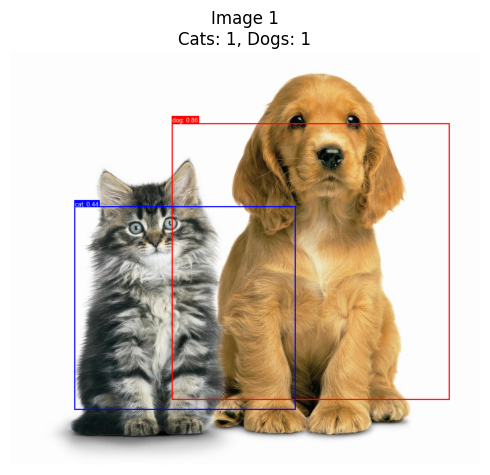

In [ ]:
def load_model_for_inference(model_path, device='cpu'):
    dummy_anchors = torch.tensor([[1.0, 1.0], [2.0, 2.0], [3.0, 3.0]])  
    model = SimpleResNetYOLO(
        anchor_boxes=dummy_anchors,
        grid_size=experiment_config['grid_size']
    ).to(device)
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print(f"Loaded model from {model_path}")
    print(f"Model was trained for {checkpoint['epoch']} epochs")
    print(f"Best validation loss: {checkpoint['loss']:.4f}")
    print(f"Loaded anchors from model: {model.anchors}")
    
    return model

def inference_on_images(model, image_paths, device='cpu', conf_threshold=0.4, target_size=(224, 224)):
    from PIL import Image, ImageDraw, ImageFont
    import torchvision.transforms as transforms
    
    anchors = model.anchors
    
    if isinstance(image_paths, str):
        image_paths = [image_paths]
    
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    class_names = {0: 'dog', 1: 'cat'}
    colors = {0: 'red', 1: 'blue'}
    
    num_images = len(image_paths)
    cols = min(3, num_images)
    rows = (num_images + cols - 1) // cols
    
    _, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    if num_images == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    model.eval()
    with torch.no_grad():
        for idx, image_path in enumerate(image_paths):
            original_image = Image.open(image_path).convert('RGB')
            original_size = original_image.size
            
            input_tensor = transform(original_image).unsqueeze(0).to(device)
            
            predictions = model(input_tensor)
            
            detections = decode_yolo_predictions(predictions, anchors, conf_threshold=conf_threshold,
                                                  grid_size=experiment_config['grid_size'],image_size=experiment_config['target_size'][0])
            print(detections)
            scale_x = original_size[0] / target_size[0]
            scale_y = original_size[1] / target_size[1]
            
            draw_image = original_image.copy()
            draw = ImageDraw.Draw(draw_image)
            
            detection_count = {'cat': 0, 'dog': 0}
            
            if len(detections) > 0 and len(detections[0]) > 0:
                boxes = detections[0]['boxes']
                scores = detections[0]['scores']
                labels = detections[0]['labels']

                for i in range(len(boxes)):
                    x1, y1, x2, y2 = boxes[i]
                    conf = scores[i]
                    cls = labels[i]
                    
                    x1 = int(x1 * scale_x)
                    y1 = int(y1 * scale_y)
                    x2 = int(x2 * scale_x)
                    y2 = int(y2 * scale_y)
                    
                    class_id = int(cls)
                    class_name = class_names[class_id]
                    color = colors[class_id]
                    detection_count[class_name] += 1
 
                    draw.rectangle([x1, y1, x2, y2], outline=color, width=3)
                    
                    label = f'{class_name}: {conf:.2f}'
                    
                    try:
                        font = ImageFont.truetype("/System/Library/Fonts/Arial.ttf", 16)
                    except:
                        font = ImageFont.load_default()
                    
                    bbox = draw.textbbox((0, 0), label, font=font)
                    text_width = bbox[2] - bbox[0]
                    text_height = bbox[3] - bbox[1]
                    
                    draw.rectangle([x1, y1-text_height-4, x1+text_width+4, y1], fill=color)
                    draw.text((x1+2, y1-text_height-2), label, fill='white', font=font)
            
            ax = axes[idx] if num_images > 1 else axes[0]
            ax.imshow(draw_image)
            ax.set_title(f'Image {idx+1}\nCats: {detection_count["cat"]}, Dogs: {detection_count["dog"]}')
            ax.axis('off')
            
            print(f"Image {idx+1}: {image_path}")
            print(f"  Detections: {len(detections[0]) if len(detections) > 0 else 0}")
            print(f"  Cats: {detection_count['cat']}, Dogs: {detection_count['dog']}")
    
    for idx in range(num_images, len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Load your trained model (anchors automatically loaded from model)
model_path = "checkpoints/20250811_205407/last_epoch.pth"
device = get_device()

# Load the model - anchors are now loaded automatically from the saved model
model = load_model_for_inference(model_path, device)

# Test on single image
inference_on_images(model, "./cat_and_dog.jpg", device)

# Test on m
# ultiple images
# image_paths = ["path/to/image1.jpg", "path/to/image2.jpg", "path/to/image3.jpg"]
# inference_on_images(model, image_paths, device)